In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7579757820806069123
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9054558135768589055
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import torch
for index in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_properties(index))

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


## Load Fashion MNIST Dataset

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

raw_train = datasets.FashionMNIST(root='data', train=True, download =True, transform=ToTensor())
raw_test = datasets.FashionMNIST(root='data', train=False, download =True, transform=ToTensor())

data_train = raw_train.data
out_train = raw_train.targets
data_test = raw_test.data
out_test = raw_test.targets

(data_train.shape, out_train.shape), (data_test.shape, out_test.shape)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



((torch.Size([60000, 28, 28]), torch.Size([60000])),
 (torch.Size([10000, 28, 28]), torch.Size([10000])))

## Data Preprocessing

In [ ]:
print((data_train.min(), data_train.max()), (data_test.min(), data_test.max()))
in_train = data_train / 255.0 
in_test = data_test / 255.0
(in_train.min(), in_train.max()), (in_test.min(), in_test.max())

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8)) (tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))


((tensor(0.), tensor(1.)), (tensor(0.), tensor(1.)))

In [ ]:
import numpy as np
print((out_train.min(), out_train.max()),(out_test.min(), out_test.max()))
np.unique(out_train), np.unique(out_test)

(tensor(0), tensor(9)) (tensor(0), tensor(9))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [ ]:
out_train.bincount(), out_test.bincount()

(tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [ ]:
class_names = raw_train.classes
class_names_test = raw_test.classes
class_names, class_names_test

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

## Training Set

In [ ]:
import math
import matplotlib.pyplot as plt 
def my_plot(images, labels, predictions=None):
  count = len(images)
  n_cols = 10 
  n_rows = math.ceil(count / n_cols) 
  fig, axes = plt.subplots(n_rows, n_cols, figsize =(n_cols+3, n_rows*2))
  
  for index in range(count):
    ax = axes.flat[index]
    ax.imshow(images[index], cmap=plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[labels[index]]) 
    if predictions is not None:
      ax.set_xlabel(class_names[predictions[index]])

  for index in range(count, n_rows*n_cols):
    axes.flat[index].axis('off')

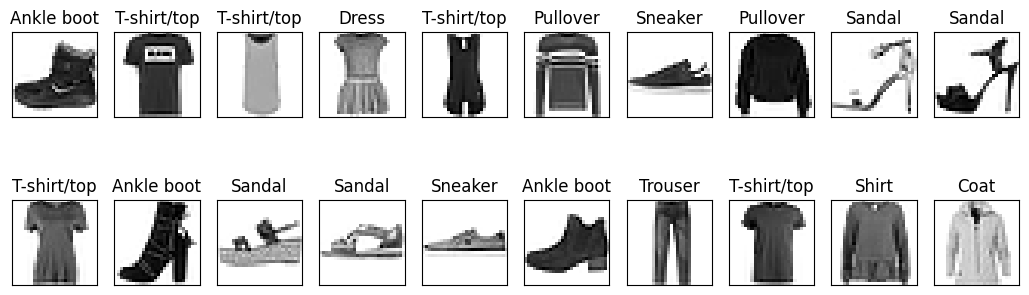

In [ ]:
my_plot(in_train[:20], out_train[:20])

## Model in PyTorch

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import random
import numpy as np
import torch.optim as optim

seed=123
random.seed(seed)
np.random.seed(seed)

hidden_size = 128
input_size = 28 * 28
output_size = 10
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,output_size),
    nn.Softmax(dim=1)
)

loss = nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=0.001)

batch = 60
load_train = DataLoader(in_train, batch_size=batch)
label_train = DataLoader(out_train, batch_size=batch)
load_test = DataLoader(in_test, batch_size=batch)
label_test = DataLoader(out_test, batch_size=batch)

epochs = 10 
for epoch in range(epochs): 
  running_loss = 0
  for images, labels in zip(load_train, label_train):
    train = images.view(images.shape[0], -1)
    outputs = model(train)
    loss_func = loss(outputs, labels)
    optimizer.zero_grad()
    loss_func.backward()
    optimizer.step()
    running_loss += loss_func.item()
  total = 0
  correct = 0
  for images, labels in zip(load_train, label_train): 
    train = images.view(images.shape[0], -1)
    outputs = model(train)
    predictions = torch.max(outputs, 1)[1] 
    correct += (predictions == labels).sum() 
    total += len(labels)


  print(f'Epoch { epoch+1}/ {epochs} - loss: {running_loss/total} - accuracy: {correct/total}')

Epoch 1/ 10 - loss: 0.028145870369672775 - accuracy: 0.8399999737739563
Epoch 2/ 10 - loss: 0.027040573247273762 - accuracy: 0.8546666502952576
Epoch 3/ 10 - loss: 0.02682388998468717 - accuracy: 0.8603500127792358
Epoch 4/ 10 - loss: 0.02668557354013125 - accuracy: 0.8643666505813599
Epoch 5/ 10 - loss: 0.026597182804346083 - accuracy: 0.8646166920661926
Epoch 6/ 10 - loss: 0.026527972284952798 - accuracy: 0.8690166473388672
Epoch 7/ 10 - loss: 0.0264738532046477 - accuracy: 0.8758000135421753
Epoch 8/ 10 - loss: 0.026395804053544997 - accuracy: 0.873283326625824
Epoch 9/ 10 - loss: 0.026337393313646318 - accuracy: 0.8738499879837036
Epoch 10/ 10 - loss: 0.026304018276929856 - accuracy: 0.8891000151634216


In [ ]:
torch.save(model, 'model1.pt')

## Testing Set

In [ ]:
correct = 0
total = 0
probs = []
preds = []
for image, label in zip(in_test, out_test): 
  test = image.view(1, 28*28)
  with torch.no_grad():
    prob = model(test)
    pred = prob.argmax(1)
    probs.append(prob)
    preds.append(pred)
    if pred == label:
      correct += 1 
    total += 1

print(f'Tested {total} images - accuracy: {correct/total}')

Tested 10000 images - accuracy: 0.8669


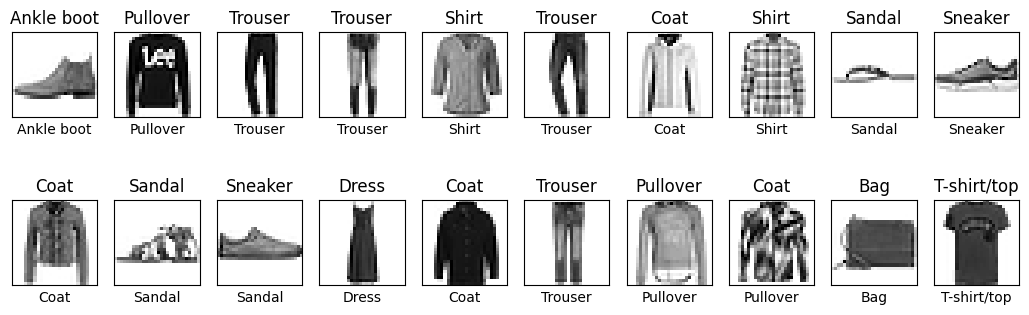

In [ ]:
my_plot(in_test[:20],out_test[:20], preds[:20])